# Crater footprint analysis

**Provides**  
High(er) level analysis of crater footprints.

**Needs**  
output from notebooks
- {doc}`crater_morphology`, both data types: the geo-tiffs (geo-jpegs) and
  the asdf stuff.
- {doc}`reduced_depths`
- Outlines of crater rims: `GraettingerDEMs/pad{i}_crateroutline.txt`

In [1]:
from pathlib import Path
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sbn
import pandas as pd
import rasterio
from rasterio.plot import show
import shapely.geometry as sg
import shapely.ops as sops

from mapview import af_line, af_triag, footprint_area
import datarepo

plt.rc('figure', figsize=(12, 10))
plt.rc('font', size=14)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}')

In [2]:
dloc = Path('../data')

In [3]:
rasterloc = dloc / 'GraettingerDEMs'
rasterloc

PosixPath('../data/GraettingerDEMs')

In [4]:
pltt = sbn.color_palette(['#2271b2', '#D55E00', '#009F81', '#F748A5',
                          '#E69F00', '#F0E442', '#3DB7E9', '#000000'])
sbn.set_palette(pltt)
pltt

[(0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.0, 0.6235294117647059, 0.5058823529411764),
 (0.9686274509803922, 0.2823529411764706, 0.6470588235294118),
 (0.9019607843137255, 0.6235294117647059, 0.0),
 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 (0.23921568627450981, 0.7176470588235294, 0.9137254901960784),
 (0.0, 0.0, 0.0)]

In [5]:
pltt2 = sbn.color_palette(['#008DF9', '#FF6E3A', '#00E307',
                           '#FFC33B', '#E20134', '#00C2F9'])
pltt2

[(0.0, 0.5529411764705883, 0.9764705882352941),
 (1.0, 0.43137254901960786, 0.22745098039215686),
 (0.0, 0.8901960784313725, 0.027450980392156862),
 (1.0, 0.7647058823529411, 0.23137254901960785),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.0, 0.7607843137254902, 0.9764705882352941)]

## Load Data

In [6]:
chargepos = datarepo.get_chargepos()
msumm = datarepo.get_byu_mics_summ()
msumm.loc[np.isnan(msumm.pmax), 'pmax'] = np.nan
byu_ch = datarepo.byu_ch
xy = datarepo.xy

## Constants \& Helper Funcs

### Material Parameters

A blast's energy, $E_\text{b}$ (in Joules), and $E_\text{b}^{1/3}$: 

In [7]:
OT = 1 / 3
SPEC_EN = 4.85e6
EBLAST = SPEC_EN * .09
EBTOT = EBLAST ** OT
EBLAST, EBTOT

(436500.0, 75.85684038249437)

#### `flatbedradius()`

Scaled radius for single shot under flat surface (units: $\mathrm{m\,J^{-1/3}}$).

$$
\bar{r}(\bar{d}) =
\begin{cases}
(\bar{r}_{0,0} - \bar{r}_\text{max})\,
\biggl(\dfrac{\bar{d}}{\bar{d}_\text{opt}} - 1\biggr)^2
+ \bar{r}_\text{max}
&,\quad \bar{d}\leq\bar{d}_\text{opt} \\
\dfrac{\bar{r}_\text{max}}{
    \sqrt{1 + \Bigl((\bar d - \bar{d}_\text{opt})
           \dfrac{\bar{r}_\text{max}}{b}\Bigr)^2}}
&,\quad \bar{d}\geq\bar{d}_\text{opt}
\end{cases}
$$

Following parameters were obtained from a best fit to data from our previous experiments.

- `RB00`, $\bar{r}_{0,0}$: 0-depth scaled radius, $2.382\times10^{-3}\,\mathrm{mJ^{-1/3}}$
- `RBMAX`, $\bar{r}_\text{max}$: max. scaled radius, $7.5125\times10^{-3}\,\mathrm{mJ^{-1/3}}$
- `DBOPT`, $\bar{d}_\text{opt}$: optimum scaled depth, $3.85\times10^{-3}\,\mathrm{mJ^{-1/3}}$
- `B`, $b$: decay constant, $1.721\times10^{-5}\,\mathrm{mJ^{-2/3}}$

In [8]:
DBOPT = 3.85e-3
RB00 = 2.382e-3
RBMAX = 7.5125e-3
B = 1.721e-5

def flatbedradius(dbar):
    dbar, conv = np.asarray(dbar), False
    if dbar.ndim == 0:
        dbar = np.array([dbar])
        conv = True
    ret = np.empty_like(dbar)
    idx = dbar <= DBOPT
    ret[idx] = -(RBMAX - RB00) * (dbar[idx] / DBOPT - 1.) ** 2 + RBMAX
    idx = ~idx
    ret[idx] = RBMAX / np.sqrt(1. + ((RBMAX / B) * (dbar[idx] - DBOPT)) ** 2)
    return ret[0] if conv else ret

In [9]:
RMAX = RBMAX * EBTOT
RMAX

0.5698745133734889

### Radius associated with a given footprint area and geometrical setup

The radius corresponding to a measured footprint area $A_\text{f}$ can be determined by visually inspecting that this is actually a footprint similar to a linear- or triangular setup, and then writing down the identity of the specific footprint ${A_\text{f} = r^2\,a_\text{f}(\beta)}$, where ${\beta = b/r}$. $a_\text{f}$ may be called the 'specific footprint', and depends on $\beta$ only (see also the {doc}`crater-footprint-formulas` notebook).

The corresponding radius can be determined by calculating the value of $\beta$ that solves

$$
\frac{A_\text{f}}{b^2}\,\beta^2 - a_\text{f}(\beta) = 0
\quad,\quad
r = \frac{b}{\beta}
\quad.
$$

Functions `rf_line()` and `rf_triag()` solve for $\beta$ numerically.

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 5)

beta = np.linspace(1e-6, 3, 300)

ax.plot(beta, af_line(beta), label=r'$a_{\text{f}, --}$')
ax.plot(beta, af_triag(beta), label=r'$a_{\text{f},\Delta}$')
ax.plot(beta, 3 * np.pi * beta ** 2, label=r'$3\pi\,\beta^2$')

ax.legend(loc='upper left')
ax.set_ylim(-.1, 11); ax.set_xlim(0, 3)
ax.set_xlabel(r'$\beta$');

Since the upper limit of $a_\text{f}$ is $3\pi$, $\beta$ must be in the interval

$$
\beta \in \biggl[0, b\,\sqrt{\frac{3\pi}{A_\text{f}}}\,\biggr]
$$

#### `rf_line()`

Returns the radius that corresponds to a measured footprint area, assuming it is a *linear* crater arrangement with center distance $b$.

In [11]:
def rf_line(fprint, b: float = .6):
    """
    Parameters
    ----------
    fprint : float
        Footprint area
    b : float
        Distance between crater centers.
    """
    beta = brentq(
        lambda bta: bta ** 2 * fprint / b ** 2 - af_line(bta),
        0, b * np.sqrt(3 * np.pi / fprint),
        maxiter=1_000_000
    )
    print(f"rf_line: β = {beta}")
    return b / beta

#### `rf_triag()`

Returns the radius that corresponds to a measured footprint area, assuming it is a *triangular* crater arrangement with center distance $b$.

In [12]:
def rf_triag(fprint, b: float = .6):
    """
    Parameters
    ----------
    fprint : float
        Footprint area
    b : float
        Distance between crater centers.
    """
    beta = brentq(
        lambda bta: bta ** 2 * fprint / b ** 2 - af_triag(bta),
        1e-3, b * np.sqrt(3 * np.pi / fprint),
        maxiter=1000000
    )
    print(f"rf_triag: β = {beta}")
    return b / beta

### Expected radius from blast under existing crater

If $r_\text{c}$ is the radius of any existing crater under which a blast occurs, and the blast has an energy $E_\text{b}$ and occurs at an (effective) depth $d$, the resulting radius $r$ can be expected to be

$$
r = r_1 + r_\text{c}\,e^{-1/n_0}\quad,
$$

if $r_\text{c}<r_\infty$. $r_1$ is the radius of the crater that would result for same scaled depth in flat topography.

In [13]:
n0 = 0.9
n0exp = np.e ** (-1 / n0)
n0exp

0.32919298780790557

In [14]:
1 - n0exp

0.6708070121920944

### Helpers

#### `load_outline()`

Load crater rim data from csv file and calculate real positions using the given
dataset's attached transform.

In [15]:
def load_outline(fname, ds):
    """
    Parameters
    ----------
    fname : str
        File name of the pixel data.
    ds : DatasetReader
        rasterio dataset/geotiff reader
    
    Returns
    -------
    pd.DataFrame
        Table with row, column, x, y values of the crater rim.
    """
    outl = pd.read_csv(fname, sep=' ', skiprows=3,
                       names=['pointnum', 'col', 'row'])
    oxy = [ds.xy(row, col)
           for row, col in zip(outl.row.values, outl.col.values)]
    outl['x'] = [el[0] for el in oxy]
    outl['y'] = [el[1] for el in oxy]
    return outl

#### `surv_area()`

The Surveyor's Area Formula to determine the area within a closed Polygon

$$
A = \frac{1}{2} \sum_{n=1}^N (x_{n-1}y_n - x_ny_{n-1})
\quad,
$$
where $n=0\dots N$, and $(x_0, y_0)=(x_N, y_N)$.

In [16]:
def surv_area(points: np.ndarray, rv='area'):
    """Calculate area enclosed by `points`.
    
    Parameters
    ----------
    points : ndarray
        2D-array of xy coordinates of the polygon's vertices, such that
        `points[:, 0]` yields all x-coordinates, and `points[:, 1] the
        y-coordinates.
    
    Returns
    -------
    int, float or tuple
        Area and/or orientation.
    """
    ret = np.sum(points[:-1, 0] * points[1:, 1]
                 - points[1:, 0] * points[:-1, 1])
    if not np.all(points[0] == points[-1]):
        ret += points[-1, 0] * points[0, 1] - points[0, 0] * points[-1, 1]
    if rv == 'area':
        ret = np.abs(.5 * ret)
    elif rv == 'orient':
        ret = np.sign(ret)
    elif rv == 'both':
        ret = (.5 * np.abs(ret), np.sign(ret))
    else:
        raise ValueError(
            'got wrong value for "rv". Expected one of "area","orient", "both"')
    return ret

#### `plot_crater_radii()`

Draw footprint and the important crater radii on top of the DEM.

In [17]:
pltt2

[(0.0, 0.5529411764705883, 0.9764705882352941),
 (1.0, 0.43137254901960786, 0.22745098039215686),
 (0.0, 0.8901960784313725, 0.027450980392156862),
 (1.0, 0.7647058823529411, 0.23137254901960785),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.0, 0.7607843137254902, 0.9764705882352941)]

In [18]:
# clrs = ['#004294', '#3AC900', '#7A0C00', '#004294']
clrs = [pltt2[0], pltt2[1], pltt2[2]]
clrs.append(clrs[0])
cprp = dict(ls=(0, (5, 5, 5, 5)), lw=1.25)

In [19]:
def legend_parts(lbls=(r'$r_\text{f}$', r'$r_{\infty,\text{max}}$',
                       r'$r_{\infty,\text{red.}}$')):
    hndls = [
        plt.matplotlib.lines.Line2D(
            [], [], color='r', marker='x', lw=0, label='charges'),
        plt.matplotlib.lines.Line2D(
            [], [], color=clrs[0], marker='.', lw=1, ls='solid',
            label='footprint')
    ]
    for lbl, clr in zip(lbls, clrs):
        hndls.append(
            plt.matplotlib.lines.Line2D(
                [], [], color=clr, label=lbl, **cprp)
        )
    return hndls

In [20]:
def plot_crater_radii(
    ax, ds, cct, radii, outline,
    lbls=(r'$r_\text{f}$', r'$r_{\infty,\text{max}}$',
          r'$r_{\infty,\text{red.}}$'),
    legend=True, axeslabels=True, ret=False):
    """Draw footprint and the important crater radii on top of the DEM. Optio-
    nally return the axes object that was used for plotting.
    
    Parameters
    ----------
    ax : matplotlib.Axes
        The matplotlib axes object to plot into.
    ds : rasterio.io.DatasetReader
        The DEM dataset
    cct : tuple
        Data frame selection of charge locations, and line numbers to use.
    radii : Iterable
        Radii of circles to draw.
    outline : pd.DataFrame
        Coordinates outlining the crater rim.
    lbls : tuple
        Labels corresponding to each radius to plot.
    ret : bool
        Whether or not to return `ax`.
    """
    cc, cclines = cct
    show(ds, ax=ax, cmap=plt.cm.gray, resample=True)
    ax.plot(cc.cc_x, cc.cc_y, 'xr', label=r'charges')
    for j, (r, clr) in enumerate(zip(radii, clrs)):
        circles = []
        for i in cclines:
            c = sg.Point(cc.cc_x[i], cc.cc_y[i]).buffer(r)
            circles.append(c)
            # ax.add_artist(
            #     plt.Circle((cc.cc_x[i], cc.cc_y[i]), radius=r,
            #                color=clr, fill=False, **cprp)
            # )
        fpcoords = sops.unary_union(circles).exterior.xy
        ax.add_artist(
            plt.Polygon(np.asarray(fpcoords).T,
                        color=clr, fill=False, **cprp)
        )
    ax.add_artist(
        plt.Polygon(outline.loc[:, xy], color=clrs[-1], fill=False))
    ax.plot(outline.loc[:, 'x'], outline.loc[:, 'y'],
            color=clrs[-1], marker='.', ms=4, lw=0)
    if axeslabels:
        ax.set_xlabel(r'$x\ /\mathrm{m}$')
        ax.set_ylabel(r'$y\ /\mathrm{m}$')
    ax.set_yticks([-1, -.5, 0, .5, 1])
    if legend:
        hndls = legend_parts()
        ax.legend(handles=hndls, loc='upper left', bbox_to_anchor=(1.02, 1))
    if ret:
        return ax

#### `qstr`: Query to select mics on radial line

In [21]:
qstr = ' | '.join(['ch == %d' % ch for ch in byu_ch['rline']['h']]) + ' | ' \
     + ' | '.join(['ch == %d' % ch for ch in byu_ch['rline']['l']])
qstr

'ch == 7 | ch == 22 | ch == 17 | ch == 19 | ch == 21 | ch == 25 | ch == 27 | ch == 29 | ch == 6 | ch == 15 | ch == 14 | ch == 16 | ch == 18 | ch == 20 | ch == 24 | ch == 26 | ch == 28'

### Max. possible footprint area for this energy

in $\mathrm{m}^2$

**Linear charge setup**

In [22]:
tmp = RBMAX * EBTOT / (1 - n0exp)
af_line(.6 / tmp) * np.pi * tmp ** 2

13.392612920084293

**Triangular charge setup**

In [23]:
tmp = RBMAX * EBTOT / (1 - n0exp)
af_triag(.6 / tmp) * np.pi * tmp ** 2

12.314935855308525

## Pad 1

### Crater Data

Load crater hill shade in crater coordinate system

In [24]:
ds1 = rasterio.open(rasterloc / "pad1_1.276mm_hillshade_ccoords.jpg", mode="r")

Pad 1 charge locations

In [25]:
cc1 = chargepos.loc[chargepos['pad'] == 1]
cc1

pad  blast    sc_x    sc_y     sc_z      cc_x      cc_y  cc_z
0    1      1  15.481  51.474 -1.74125 -0.616688 -0.011401  -0.3
1    1      2  16.096  51.427 -1.74125  0.000000  0.000000  -0.3
2    1      3  16.712  51.357 -1.74125  0.619860 -0.011401  -0.3
3    1      4  15.481  51.474 -2.04125 -0.616688 -0.011401  -0.6
4    1      5  16.096  51.427 -2.04125  0.000000  0.000000  -0.6
5    1      6  16.712  51.357 -2.04125  0.619860 -0.011401  -0.6

Load crater outline polygon (location of the crater's highest elevation/rim)

In [26]:
outl1 = load_outline(rasterloc / 'pad1_crateroutline.txt', ds1)
outl1a = load_outline(rasterloc / 'pad1_crateroutline-a.txt', ds1)

### Footprint Area

Footprint area in $\mathrm{m}^2$ (`fp1`) and corresponding characteristic radius in $\mathrm{m}$ (`rf1`).

In [27]:
fp1 = surv_area(outl1.loc[:, xy].values)
rf1 = rf_line(fp1)
fp1, rf1

rf_line: β = 0.8051461713439833


(3.4835663791772338, 0.7452063008614388)

In [28]:
fp1a = surv_area(outl1a.loc[:, xy].values)
rf1a = rf_line(fp1a)
fp1a, rf1a

rf_line: β = 0.7728914625357939


(3.708943627145433, 0.7763056380923771)

### Reduced Scaled Depth

Average value of reduced scaled depth from radial BYU mics line. (In $\mathrm{m\,J^{-1/3}}$.)

In [29]:
sel1 = msumm.loc[msumm['pad'] == 1]
sel2 = sel1.query(qstr)
sel3 = sel2.loc[sel2.t == 1.5]
dredbar1 = sel3.dredbar.mean()
σdredbar1 = sel3.dredbar.std()
print(
    f"dredbar1:             {dredbar1:.2e}",
    f"σdredbar1:            {σdredbar1:.2e}",
    f"σdredbar1 / dredbar1: {σdredbar1 / dredbar1:.2e}", sep='\n')

dredbar1:             4.56e-03
σdredbar1:            3.53e-04
σdredbar1 / dredbar1: 7.74e-02


### Radii

- `rr01_1`: Flat topography radius for first blast at reduced scaled depth  
- `rrinf_1`: Asymptotic radius for many blasts at reduced scaled depth.
- `rmax_1`: Radius for first blast at optimum scaled depth  
- `rmaxinf_1`: maximum radius that can be achieved by many blasts of energy $E_\text{b}$.

In [30]:
rmax_1 = RBMAX * EBTOT
rr01_1 = flatbedradius(dredbar1) * EBTOT
rmaxinf_1 = rmax_1 / (1 - n0exp)
rrinf_1 = rr01_1 / (1 - n0exp)
print(f"rr01_1:    {rr01_1:.2e}",
      f"rrinf_1:   {rrinf_1:.2e}",
      f"rmax_1:    {rmax_1:.2e}",
      f"rmaxinf_1: {rmaxinf_1:.2e}", sep='\n')

rr01_1:    5.44e-01
rrinf_1:   8.11e-01
rmax_1:    5.70e-01
rmaxinf_1: 8.50e-01


Estimate of crater radius at detonation time of lower charge:

In [31]:
rc1 = rrinf_1 - (rrinf_1 - rf1a) / n0exp
rc1

0.7047642202203206

#### Show crater and some of the radii

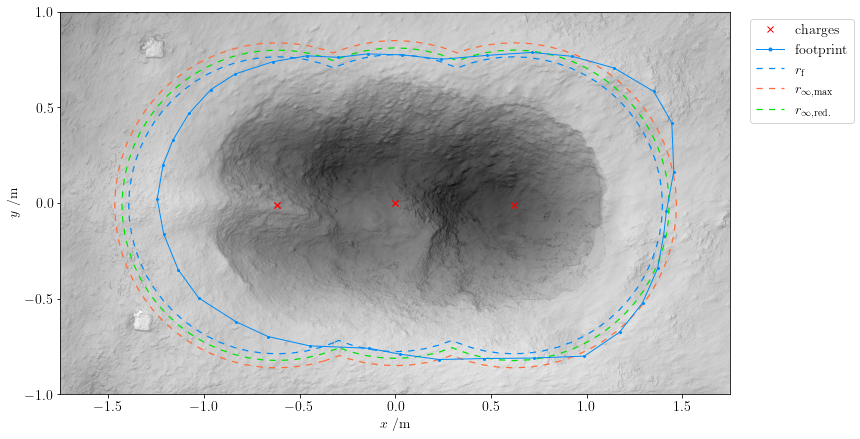

In [32]:
fig, ax = plt.subplots()
plot_crater_radii(ax, ds1, (cc1, [0, 1, 2]), (rf1a, rmaxinf_1, rrinf_1), outl1a)

## Pad 2

### Crater Data

Load crater hill shade in crater coordinate system

In [33]:
ds2 = rasterio.open(rasterloc / 'pad2_1.214mm_hillshade_ccoords.jpg', mode='r')

Pad 2 charge locations

In [34]:
cc2 = chargepos.loc[chargepos['pad'] == 2]
cc2

pad  blast    sc_x    sc_y  sc_z      cc_x      cc_y  cc_z
6     2      1  19.100  51.213 -1.72 -0.620477 -0.008279  -0.3
7     2      2  19.100  51.213 -2.02 -0.620477 -0.008279  -0.6
8     2      3  19.718  51.157 -1.72  0.000000  0.000000  -0.3
9     2      4  19.718  51.157 -2.02  0.000000  0.000000  -0.6
10    2      5  20.349  51.083 -1.72  0.635270 -0.008279  -0.3
11    2      6  20.349  51.083 -2.02  0.635270 -0.008279  -0.6

Load crater outline polygon (location of the crater's highest elevation/rim)

In [35]:
outl2 = load_outline(rasterloc / 'pad2_crateroutline.txt', ds2)

In [36]:
outl2.head(2)

pointnum  col  row         x         y
0         0  296  822 -1.390120  0.001683
1         1  330  692 -1.348853  0.159472

### Footprint Area

Footprint area in $\mathrm{m}^2$ (`fp2`) and corresponding characteristic radius in $\mathrm{m}$ (`rf2`).

In [37]:
fp2 = surv_area(outl2.loc[:, xy].values)
rf2 = rf_line(fp2)
fp2, rf2

rf_line: β = 0.8210678341170405


(3.3808451161854958, 0.7307557001611538)

### Reduced Scaled Depth

Average value of reduced scaled depth from radial BYU mics line. (In $\mathrm{m\,J^{-1/3}}$.)

In [38]:
sel1 = msumm.loc[msumm['pad'] == 2]
sel2 = sel1.query(qstr)
sel3 = sel2.loc[sel2.t == 0.5]
dredbar2 = sel3.dredbar.mean()
σdredbar2 = sel3.dredbar.std()
dredbar2, σdredbar2, σdredbar2 / dredbar2
print(
    f"dredbar2:             {dredbar2:.2e}",
    f"σdredbar2:            {σdredbar2:.2e}",
    f"σdredbar2 / dredbar1: {σdredbar2 / dredbar2:.2e}", sep='\n')

dredbar2:             2.51e-03
σdredbar2:            4.39e-04
σdredbar2 / dredbar1: 1.75e-01


### Radii

- `rr01_2`: Flat topography radius for first blast at reduced scaled depth  
- `rrinf_2`: Asymptotic radius for many blasts at reduced scaled depth.
- `rmax_2`: Radius for first blast at optimum scaled depth  
- `rmaxinf_2`: maximum radius that can be achieved by many blasts of energy $E_\text{b}$.

In [39]:
rmax_2 = RBMAX * EBTOT
rr01_2 = flatbedradius(dredbar2) * EBTOT
rmaxinf_2 = rmax_2 / (1 - n0exp)
rrinf_2 = rr01_2 / (1 - n0exp)
print(f"rr01_1:    {rr01_1:.2e}",
      f"rrinf_1:   {rrinf_1:.2e}",
      f"rmax_1:    {rmax_1:.2e}",
      f"rmaxinf_1: {rmaxinf_1:.2e}", sep='\n')

rr01_1:    5.44e-01
rrinf_1:   8.11e-01
rmax_1:    5.70e-01
rmaxinf_1: 8.50e-01


Estimate of crater radius at detonation time of lower charge:

In [40]:
rc2 = rrinf_2 - (rrinf_2 - rf2) / n0exp
rc2

0.6313821933337949

### Show crater and some radii

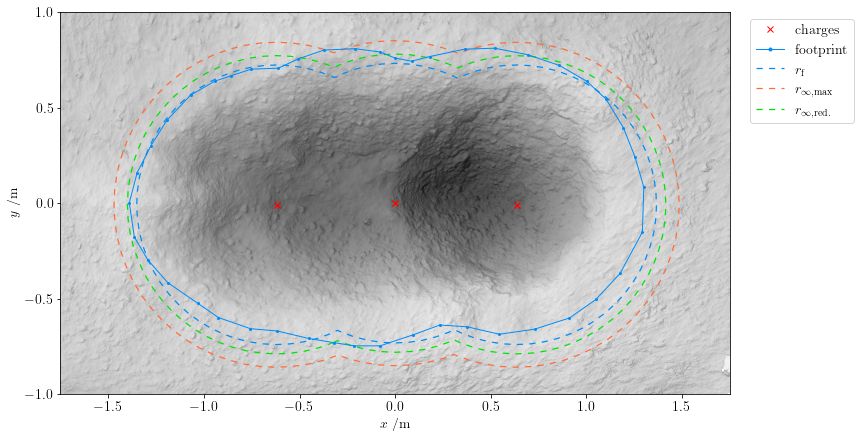

In [41]:
fig, ax = plt.subplots()
plot_crater_radii(ax, ds2, (cc2, [6, 8, 10]), (rf2, rmaxinf_2, rrinf_2), outl2)

## Pad 3

### Crater Data

In [42]:
ds3 = rasterio.open(rasterloc / 'pad3_1.425mm_hillshade_ccoords.jpg', mode='r')

#### Pad 3 Charge Locations

In [43]:
cc3 = chargepos.loc[chargepos['pad'] == 3]
cc3

pad  blast    sc_x    sc_y     sc_z      cc_x      cc_y  cc_z
12    3      1  23.183  50.533 -1.70975 -0.014282  0.345372  -0.3
13    3      2  23.493  50.002 -1.70975  0.316894 -0.172686  -0.3
14    3      3  22.874  50.027 -1.70975 -0.302611 -0.172686  -0.3
15    3      4  23.183  50.533 -2.00975 -0.014282  0.345372  -0.6
16    3      5  23.493  50.002 -2.00975  0.316894 -0.172686  -0.6
17    3      6  22.874  50.027 -2.00975 -0.302611 -0.172686  -0.6

Load crater outline polygon (location of the crater's highest elevation/rim).

In [44]:
outl3 = load_outline(rasterloc / 'pad3_crateroutline.txt', ds3)
outl3.head(2)

pointnum  col  row         x         y
0         0  842  150 -0.299437  1.035537
1         1  786  168 -0.379237  1.009888

### Footprint Area

Footprint area in $\mathrm{m}^2$ (`fp3`) and corresponding characteristic radius in $\mathrm{m}$ (`rf3`).

In [45]:
fp3 = surv_area(outl3.loc[:, xy].values)
rf3 = rf_triag(fp3)
fp3, rf3

rf_triag: β = 0.8818666147092635


(2.7939044475000006, 0.6803750022874036)

### Reduced Scaled Depth

Average value of reduced scaled depth from radial BYU mics line. (In $\mathrm{m\,J^{-1/3}}$.)

In [46]:
sel1 = msumm.loc[msumm['pad'] == 3]
sel2 = sel1.query(qstr)
sel3 = sel2.loc[sel2.t == 1.5]
dredbar3 = sel3.dredbar.mean()
σdredbar3 = sel3.dredbar.std()
print(
    f"dredbar3:             {dredbar3:.2e}",
    f"σdredbar3:            {σdredbar3:.2e}",
    f"σdredbar3 / dredbar3: {σdredbar3 / dredbar3:.2e}", sep='\n')

dredbar3:             4.38e-03
σdredbar3:            7.51e-04
σdredbar3 / dredbar3: 1.71e-01


### Radii

- `rr01_3`: Flat topography radius for first blast at reduced scaled depth  
- `rrinf_3`: Asymptotic radius for many blasts at reduced scaled depth.
- `rmax_3`: Radius for first blast at optimum scaled depth  
- `rmaxinf_3`: maximum radius that can be achieved by many blasts of energy $E_\text{b}$.

In [47]:
rmax_3 = RBMAX * EBTOT
rr01_3 = flatbedradius(dredbar3) * EBTOT
rmaxinf_3 = rmax_3 / (1 - n0exp)
rrinf_3 = rr01_3 / (1 - n0exp)
print(
    f"rr01_3:    {rr01_3:.2e}",
    f"rrinf_3:   {rrinf_3:.2e}",
    f"rmax_3:    {rmax_3:.2e}",
    f"rmaxinf_3: {rmaxinf_3:.2e}", sep='\n')

rr01_3:    5.55e-01
rrinf_3:   8.28e-01
rmax_3:    5.70e-01
rmaxinf_3: 8.50e-01


Estimate of crater radius at detonation time of lower charge:

In [48]:
rc3 = rrinf_3 - (rrinf_3 - rf3) / n0exp
rc3

0.3805700442922267

#### Show crater and some of the radii

In [49]:
fig, ax = plt.subplots()
plot_crater_radii(ax, ds3, (cc3, (12, 13, 14)), (rf3, rmaxinf_3, rrinf_3), outl3)

## Pad 4

### Crater Data

In [50]:
ds4 = rasterio.open(rasterloc / 'pad4_2.512mm_hillshade.3_ccoords.jpg', mode='r')

Pad 4 charge locations

In [51]:
cc4 = chargepos.loc[chargepos['pad'] == 4]
cc4

pad  blast    sc_x    sc_y    sc_z      cc_x      cc_y  cc_z
18    4      1  26.317  50.168 -1.7155 -0.001713  0.347339  -0.3
19    4      2  26.317  50.168 -2.0155 -0.001713  0.347339  -0.6
20    4      3  26.581  49.628 -1.7155  0.298030 -0.173669  -0.3
21    4      4  26.581  49.628 -2.0155  0.298030 -0.173669  -0.6
22    4      5  25.988  49.668 -1.7155 -0.296317 -0.173669  -0.3
23    4      6  25.988  49.668 -2.0155 -0.296317 -0.173669  -0.6

Load crater outline polygon

In [52]:
outl4 = load_outline(rasterloc / 'pad4_crateroutline.txt', ds4)
outl4a = load_outline(rasterloc / 'pad4_crateroutline-a.txt', ds4)

In [53]:
outl4a.head(2)

pointnum  col  row         x         y
0         0  587   88 -0.024248  1.027695
1         1  535  100 -0.154867  0.997552

### Footprint Area

In [54]:
fp4 = surv_area(outl4.loc[:, xy].values)
rf4 = rf_triag(fp4)
fp4, rf4

rf_triag: β = 0.8639977713111272


(2.8808901624218026, 0.694446235769211)

In [55]:
fp4a = surv_area(outl4a.loc[:, xy].values)
rf4a = rf_triag(fp4a)
fp4a, rf4a

rf_triag: β = 0.8171183841477789


(3.13373078050497, 0.734287725793583)

### Reduced Scaled Depth

In [56]:
sel1 = msumm.loc[msumm['pad'] == 4]
sel2 = sel1.query(qstr)
sel3 = sel2.loc[sel2.t == 0.5]
dredbar4 = sel3.dredbar.mean()
σdredbar4 = sel3.dredbar.std()
print(
    f"dredbar4:             {dredbar4:.2e}",
    f"σdredbar4:            {σdredbar4:.2e}",
    f"σdredbar4 / dredbar4: {σdredbar4 / dredbar4:.2e}", sep='\n')

dredbar4:             2.98e-03
σdredbar4:            3.46e-04
σdredbar4 / dredbar4: 1.16e-01


### Radii

- `rr01_4`: Flat topography radius for first blast at reduced scaled depth  
- `rrinf_4`: Asymptotic radius for many blasts at reduced scaled depth.
- `rmax_4`: Radius for first blast at optimum scaled depth  
- `rmaxinf_4`: maximum radius that can be achieved by many blasts of energy $E_\text{b}$.

In [57]:
rmax_4 = RBMAX * EBTOT
rr01_4 = flatbedradius(dredbar4) * EBTOT
rmaxinf_4 = rmax_4 / (1 - n0exp)
rrinf_4 = rr01_4 / (1 - n0exp)
print(
    f"rr01_4:    {rr01_4:.2e}",
    f"rrinf_4:   {rrinf_4:.2e}",
    f"rmax_4:    {rmax_4:.2e}",
    f"rmaxinf_4: {rmaxinf_4:.2e}", sep='\n')

rr01_4:    5.50e-01
rrinf_4:   8.20e-01
rmax_4:    5.70e-01
rmaxinf_4: 8.50e-01


In [58]:
rc4 = rrinf_4 - (rrinf_4 - rf4) / n0exp
rc4a = rrinf_4 - (rrinf_4 - rf4a) / n0exp
rc4, rc4a

(0.4393057393487443, 0.5603334996594249)

### Show crater and some radii

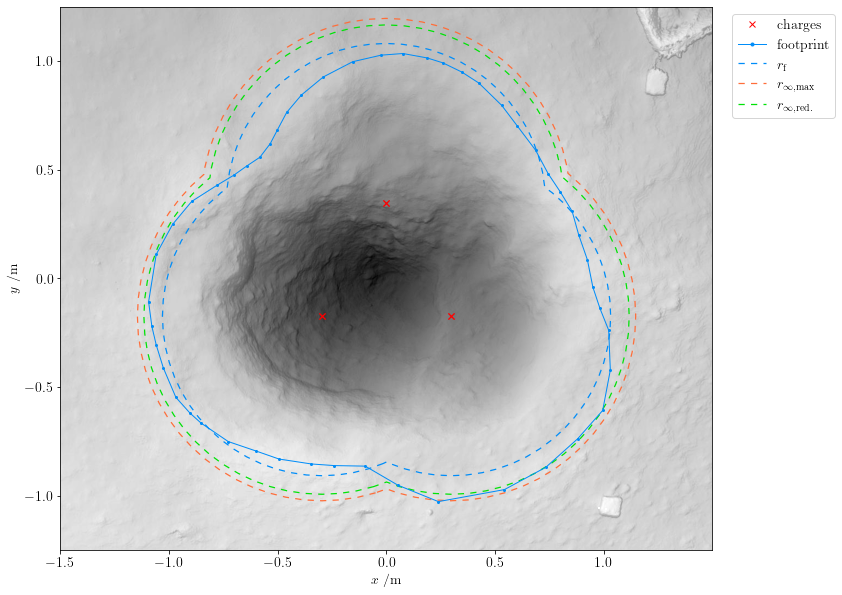

In [59]:
fig, ax = plt.subplots()
plot_crater_radii(ax, ds4, (cc4, [18, 20, 22]),
                  (rf4a, rmaxinf_4, rrinf_4), outl4a)

## All 4 Craters

### Plot

In [60]:
%%capture
fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(top=1, bottom=0, left=.07, right=.97)

sf1, sf2, sf3 = fig.subfigures(nrows=3, hspace=0, height_ratios=[11, 1, 13])
ax1, ax2 = sf1.subplots(ncols=2)
axleg = sf2.subplots()
axs = sf3.subplots(ncols=6, gridspec_kw={'width_ratios': [1, 28, 1, 1, 28, 1]})
ax3, ax4 = axs[[1, 4]]
for ax in axs[[0, 2, 3, 5]]:
    ax.set_xticks([]); ax.set_yticks([])
    for side in ('top', 'right', 'bottom', 'left'):
        ax.spines[side].set_visible(False)

In [61]:
plot_crater_radii(ax1, ds1, (cc1, [0, 1, 2]), (rf1a, rmaxinf_1, rrinf_1),
                  outl1a, axeslabels=True, legend=False)
plot_crater_radii(ax2, ds2, (cc2, [6, 8, 10]), (rf2, rmaxinf_2, rrinf_2),
                  outl2, axeslabels=True, legend=False)
plot_crater_radii(ax3, ds3, (cc3, (12, 13, 14)), (rf3, rmaxinf_3, rrinf_3),
                  outl3, axeslabels=True, legend=False)
plot_crater_radii(ax4, ds4, (cc4, [18, 20, 22]), (rf4a, rmaxinf_4, rrinf_4),
                  outl4a, axeslabels=True, legend=False)
for i, ax in enumerate((ax1, ax2, ax3, ax4)):
    ax.set_title('Pad %d' % (i + 1))
for ax in (ax1, ax2):
    ax.set_xlim(-1.75, 1.75)
    ax.set_ylim(-1., 1.)
for ax in (ax3, ax4):
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.25, 1.25)

for sp in axleg.spines.values():
    sp.set_visible(False)
axleg.set_xticks([])
axleg.set_yticks([])
axleg.legend(handles=legend_parts(),
             loc='center', bbox_to_anchor=(.5, .0), ncol=5)
# fig.subplots_adjust(top=.95)
# fig.set_size_inches(12.5, 9.5)

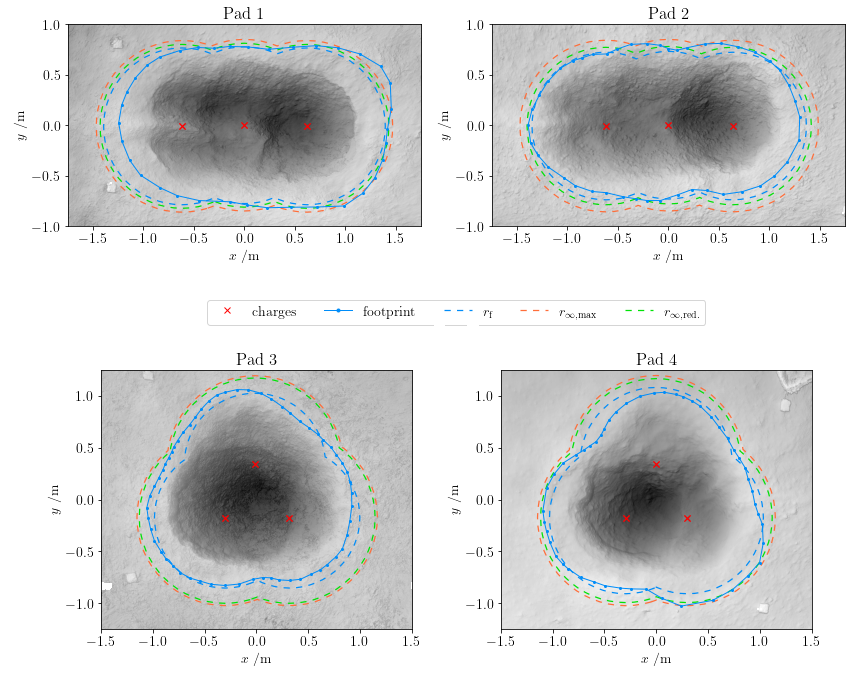

In [62]:
fig

### Radii vs. Time

In [63]:
clrs = ['#006CD1', '#00D165', '#D1006C', '#D16500']
mrk = ['x', 'x', '^', '^']

In [64]:
rf = np.array([rf1a, rf2, rf3, rf4a])
rrinf = np.array([rrinf_1, rrinf_2, rrinf_3, rrinf_4])
dt = np.array([1.5, .5, 1.5, .5])

fp = np.array([fp1a, fp2, fp3, fp4a])
funcs = [af_line, af_line, af_triag, af_triag]
fpmax = np.array([footprint_area(rmaxinf_1, .6, func) for func in funcs])
arinf = np.array([footprint_area(r, .6, func) for r, func in zip(rrinf, funcs)])

(0.0, 1.25)

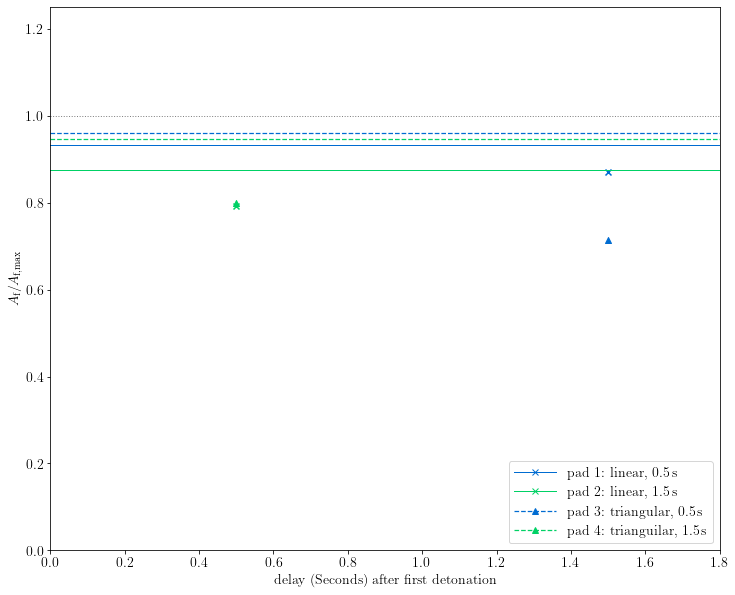

In [65]:
fig, ax = plt.subplots()

ax.axhline(y=1, ls='dotted', lw=1, color='gray')
ax.axhline(y=arinf[0] / fpmax[0], lw=1, ls='solid', color=clrs[0],
           label='pad 1')
ax.scatter(dt[0], fp[0] / fpmax[0], c=clrs[0], marker='x')
ax.axhline(y=arinf[1] / fpmax[1], lw=1, ls='solid', color=clrs[1],
           label='pad 2')
ax.scatter(dt[1], fp[1] / fpmax[1], c=clrs[1], marker='x')
ax.axhline(y=arinf[2] / fpmax[2], lw=1.25, ls='dashed', color=clrs[0],
           label='pad 3')
ax.scatter(dt[2], fp[2] / fpmax[2], c=clrs[0], marker='^')
ax.axhline(y=arinf[3] / fpmax[3], lw=1.25, ls='dashed', color=clrs[1],
           label=r'pad 4')
ax.scatter(dt[3], fp[3] / fpmax[3], c=clrs[1], marker='^')

ax.set_ylabel(r'$A_\text{f} / A_\text{f,max}$')
ax.set_xlabel(r'delay (Seconds) after first detonation')
ax.legend(
    loc='lower right',
    handles=[
        plt.matplotlib.lines.Line2D(
            [], [], color=clrs[0], marker='x', lw=1, ls='solid',
            label=r'pad 1: linear, 0.5\,s'),
        plt.matplotlib.lines.Line2D(
            [], [], color=clrs[1], marker='x', lw=1, ls='solid',
            label=r'pad 2: linear, 1.5\,s'),
        plt.matplotlib.lines.Line2D(
            [], [], color=clrs[0], marker='^', lw=1.25, ls='dashed',
            label='pad 3: triangular, 0.5\,s'),
        plt.matplotlib.lines.Line2D(
            [], [], color=clrs[1], marker='^', lw=1.25, ls='dashed',
            label='pad 4: trianguilar, 1.5\,s')
    ],
    handlelength=3
)
ax.set_xlim(0, 1.8)
ax.set_ylim(0, 1.25)

## Export Crater Outlines

Only run this if you want to build the asdf database.

In [66]:
import asdf

In [67]:
aff = asdf.open(dloc / 'UB/storage/crater-morphology.asdf', mode='rw')

In [68]:
aff.find_references()
aff.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): Space Telescope Science Institute
│ ├─homepage (str): http://github.com/spacetelescope/asdf
│ ├─name (str): asdf
│ └─version (str): 2.7.1
├─history (dict)
│ └─extensions (list) ...
├─charge_coords (dict)
│ ├─blast (NDArrayType): shape=(24,), dtype=int64
│ ├─cc_x (NDArrayType): shape=(24,), dtype=float64
│ ├─cc_y (NDArrayType): shape=(24,), dtype=float64
│ ├─cc_z (NDArrayType): shape=(24,), dtype=float64
│ ├─columns (list) ...
│ ├─comment (dict) ...
│ ├─pad (NDArrayType): shape=(24,), dtype=int64
│ ├─sc_x (NDArrayType): shape=(24,), dtype=float64
│ ├─sc_y (NDArrayType): shape=(24,), dtype=float64
│ └─sc_z (NDArrayType): shape=(24,), dtype=float64
├─comment (dict) ...
├─crater-footprint (dict) ...
├─crater-outlines (dict) ...
└─profiles (dict) ...
Some nodes not shown.


In [69]:
aff['crater-outlines'] = {
    'index_col': 0,
    'columns': list(outl1.columns),
    'dtypes': [str(dt) for dt in outl1.dtypes],
    'pad1': {col: outl1a[col].values for col in outl1a.columns},
    'pad2': {col: outl2[col].values for col in outl2.columns},
    'pad3': {col: outl3[col].values for col in outl3.columns},
    'pad4': {col: outl4a[col].values for col in outl4a.columns},
    'note': "Crater rim: highest elevation of crater. This was manually "
            "determined in imageJ."
}

aff['crater-footprint'] = {f'pad{i}': fpi for i, fpi in enumerate(fp, start=1)}
aff['crater-footprint']['units'] = 'square meter'
aff['footprint-radius'] = {f'pad{i}': ri for i, ri in enumerate(rf, start=1)}
aff['footprint-radius']['units'] = 'meter'
aff['max-radius'] = {'value': rmaxinf_1, 'unit': 'meter'}
aff['max-footprint'] = {f'pad{i}': fpi for i, fpi in enumerate(fpmax, start=1)}
if 'comment' not in aff.keys():
    aff['comment'] = {}
aff['comment']['anl/footprint_analysis.ipynb'] = {
    'note': 'Created elements: "crater-outlines", "crater-footprint"',
    'run_after': ['anl/crater_morphology.ipynb', 'anl/reduced_depths.ipynb']
}

In [70]:
aff.close()